Religion_and_belief_systems and layer & token level

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

/rds/general/user/jj1122/home/anaconda3/envs/test1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
dataset_nm = "Health_and_fitness"
dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"

In [3]:
device_id = 'cuda'
tuned_model_path = "../m2d2/dataset/Health_and_fitness/models/checkpoint-20000/"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [4]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


# Model

## load models

In [5]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [230]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

## save_tuned_model_activation_hook

In [6]:
def save_tuned_model_activation(m_id):
    def save_tuned_model_activation_hook(module, _input, _output):
        if m_id.endswith('attn'):
            tuned_model_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
            tuned_model_activations[m_id] = _output.detach()
    return save_tuned_model_activation_hook

## restore_tuned_model_activation_hook

In [7]:
def restore_base_model_activation(m_id, t):
    def restore_base_model_activation_hook(module, _input, _output):
        tuned_output = tuned_model_activations[m_id][:, t]
        if m_id.endswith('attn'):
            base_output = _output[0].detach()
            base_output[:, t] = tuned_output
            return tuple([base_output, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):
            base_output = _output.detach()
            base_output[:, t] = tuned_output
            return base_output
    return restore_base_model_activation_hook

In [8]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [9]:
dataset = load_dataset("text", data_files=dataset_path)


Found cached dataset text (/rds/general/user/jj1122/home/.cache/huggingface/datasets/text/default-586044b5385f1284/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)
100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


In [40]:
input_text =  "A diabetic bulla is a cutaneous condition characterized by a noninflammatory, spontaneous, painless blister, often in acral locations"

input_text = "Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults."

input_text = "The development of ichthyosis in adulthood can be a manifestation of systemic disease, and it has been described in association with malignancies, drugs, endocrine and metabolic disease, HIV, infection, and autoimmune conditions"

In [41]:
inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
n_tokens = inputs['input_ids'].shape[1]
n_tokens

44

In [42]:
list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

for idx in range(1, n_tokens):
    if not list_input_text[idx].startswith("Ġ"):
        list_input_text[idx-1] = list_input_text[idx-1] + "##"
    list_input_text[idx] = list_input_text[idx].replace("Ġ", "")

# Main

## first run - tuned model (clean)

### register hook - save_tuned_model_activation

In [43]:
tuned_model_activations = {}
for m_id in list_trace_module_ids:
    tuned_model.get_submodule(m_id).register_forward_hook(save_tuned_model_activation(m_id))

### get tuned_model_activation & tuned_loss

In [44]:
with torch.no_grad():
    tuned_model.eval()
    tuned_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
    tuned_loss = np.exp(tuned_outputs.loss.item())
    

## second run - base model (corruped)

### get tuned_model_activation & base_loss

In [45]:
with torch.no_grad():
    base_model.eval()
    base_outputs = base_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
    base_loss = np.exp(base_outputs.loss.item())
    

## Thrid run - corrupted-with-restoration run

### register hook - restore_base_model_activation & restored losses

In [46]:
restored_loss = {}
with torch.no_grad():
    tuned_model.eval()
    base_model.eval()
    for m_id in list_trace_module_ids:
        for t in range(n_tokens):
            hook = base_model.get_submodule(m_id).register_forward_hook(restore_base_model_activation(m_id, t))
            restored_outputs = base_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
            restored_loss[m_id + f".{t}"] = np.exp(restored_outputs.loss.item())
            hook.remove()
        

In [34]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn.0', 26.028664908525663),
 ('transformer.h.0.attn.1', 25.571609563948723),
 ('transformer.h.0.attn.2', 26.27090836384104),
 ('transformer.h.0.attn.3', 26.02362014929749),
 ('transformer.h.0.attn.4', 26.360276931646702),
 ('transformer.h.0.attn.5', 26.281690012063965),
 ('transformer.h.0.attn.6', 26.388498119219264),
 ('transformer.h.0.attn.7', 26.31101891464892),
 ('transformer.h.0.attn.8', 26.30940052120269),
 ('transformer.h.0.attn.9', 26.27566276974266)]

## Losses

In [18]:
tuned_loss, base_loss, np.mean(list(restored_loss.values()))

(53.06597342708043, 151.7481925136754, 151.19663228688393)

In [47]:
TE = base_loss - tuned_loss
IDE = {}
for m_id in list_trace_module_ids:
    for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = (base_loss - restored_loss[m_id + f'.{t}'])
        IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}']

In [48]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
    row['t'] = int(list_code[4])
    return row

df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

##### A diabetic bulla is a cutaneous condition characterized by a noninflammatory, spontaneous, painless blister, often in acral locations

<Axes: xlabel='None-l', ylabel='m-t-token'>

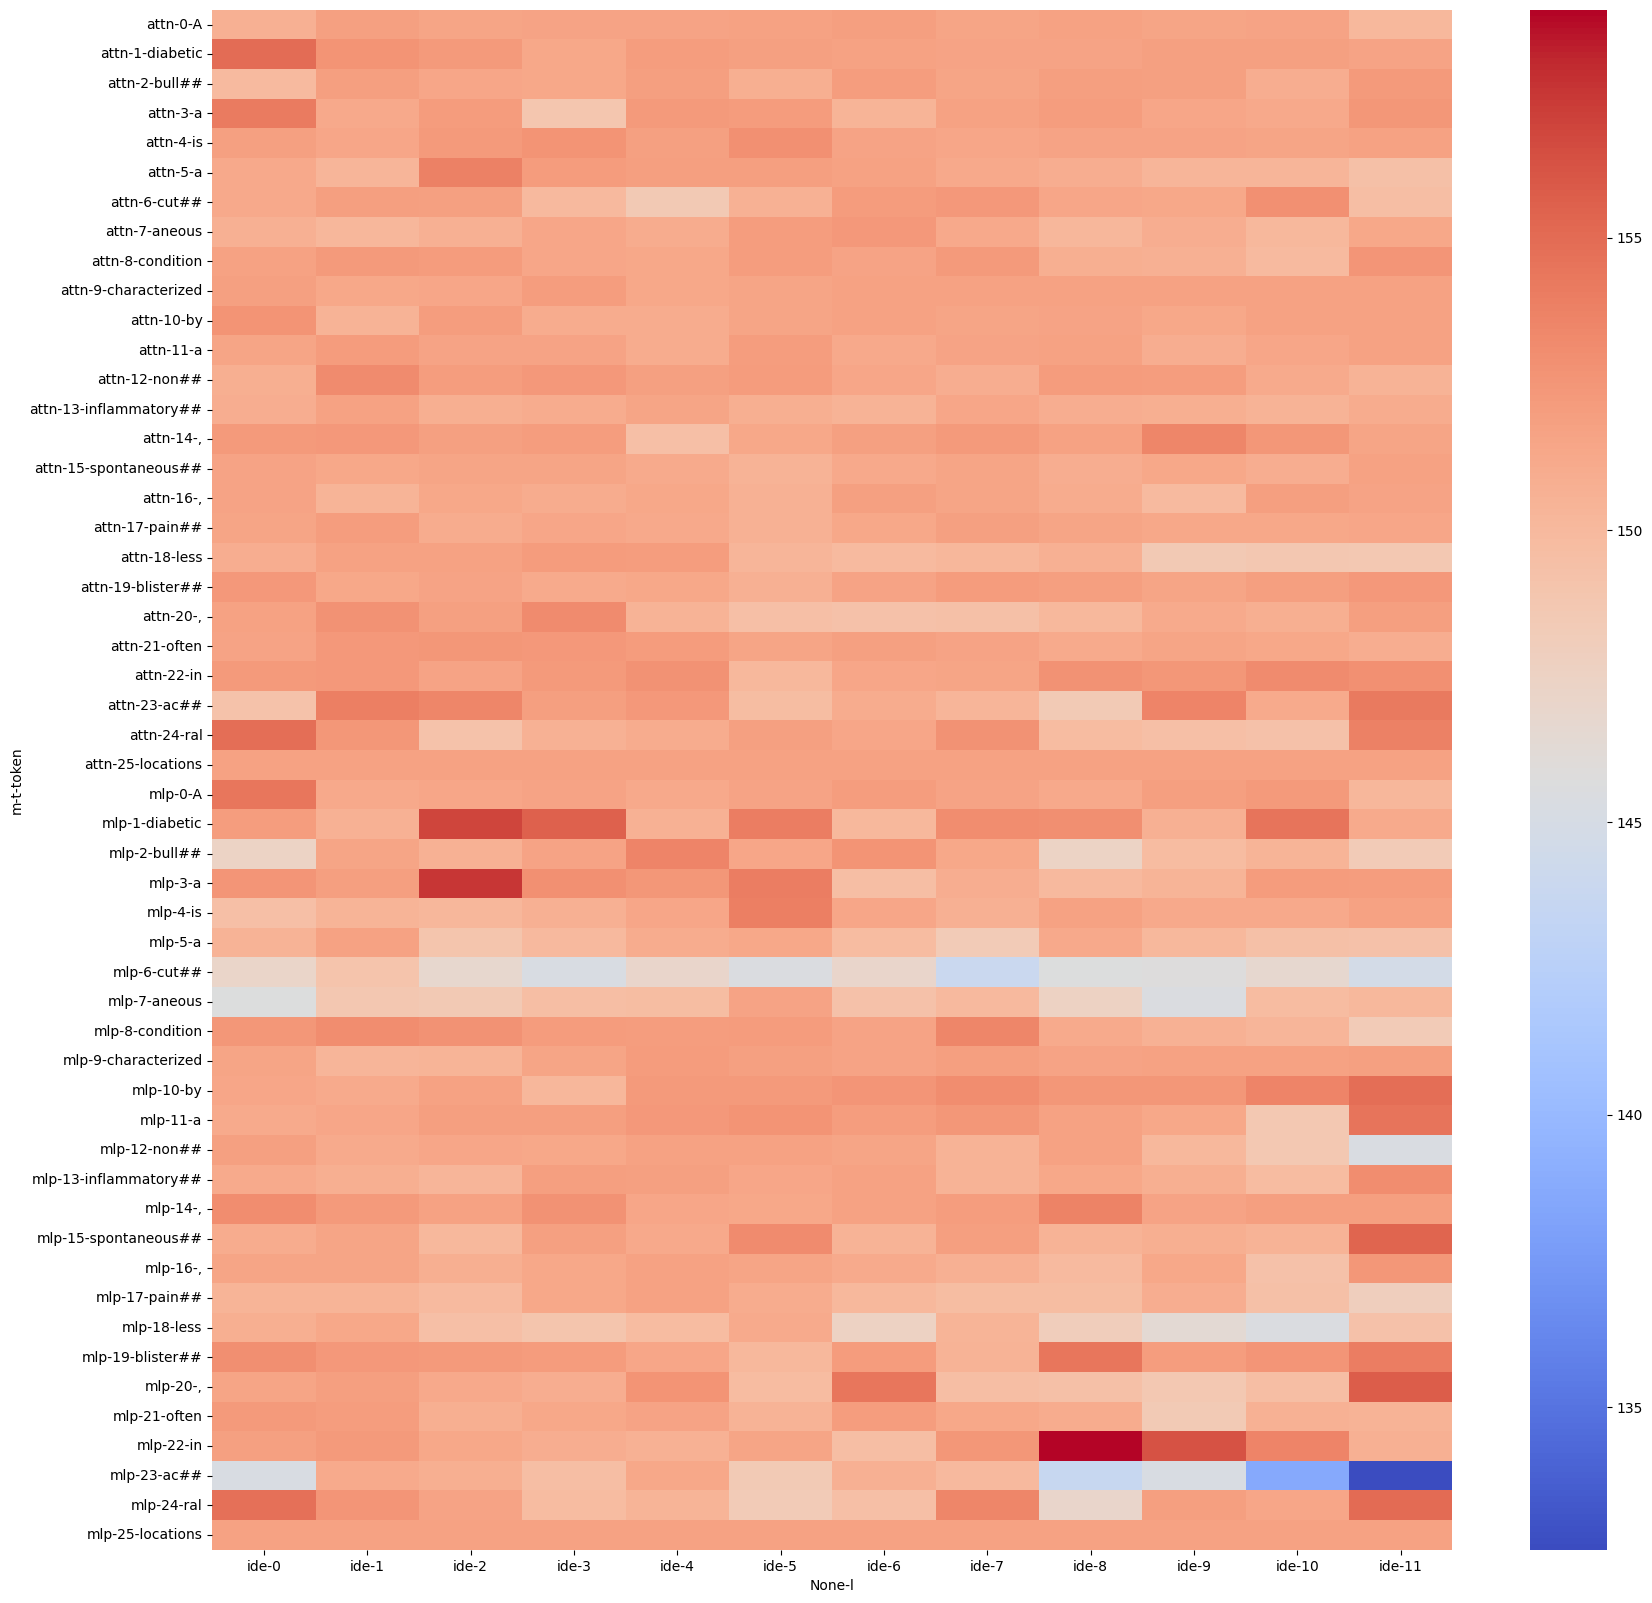

In [25]:
plt.rcParams["figure.figsize"] = (20,20)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 't', 'token', 'l']).unstack(-1),
    cmap='coolwarm'
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m-t-token'>

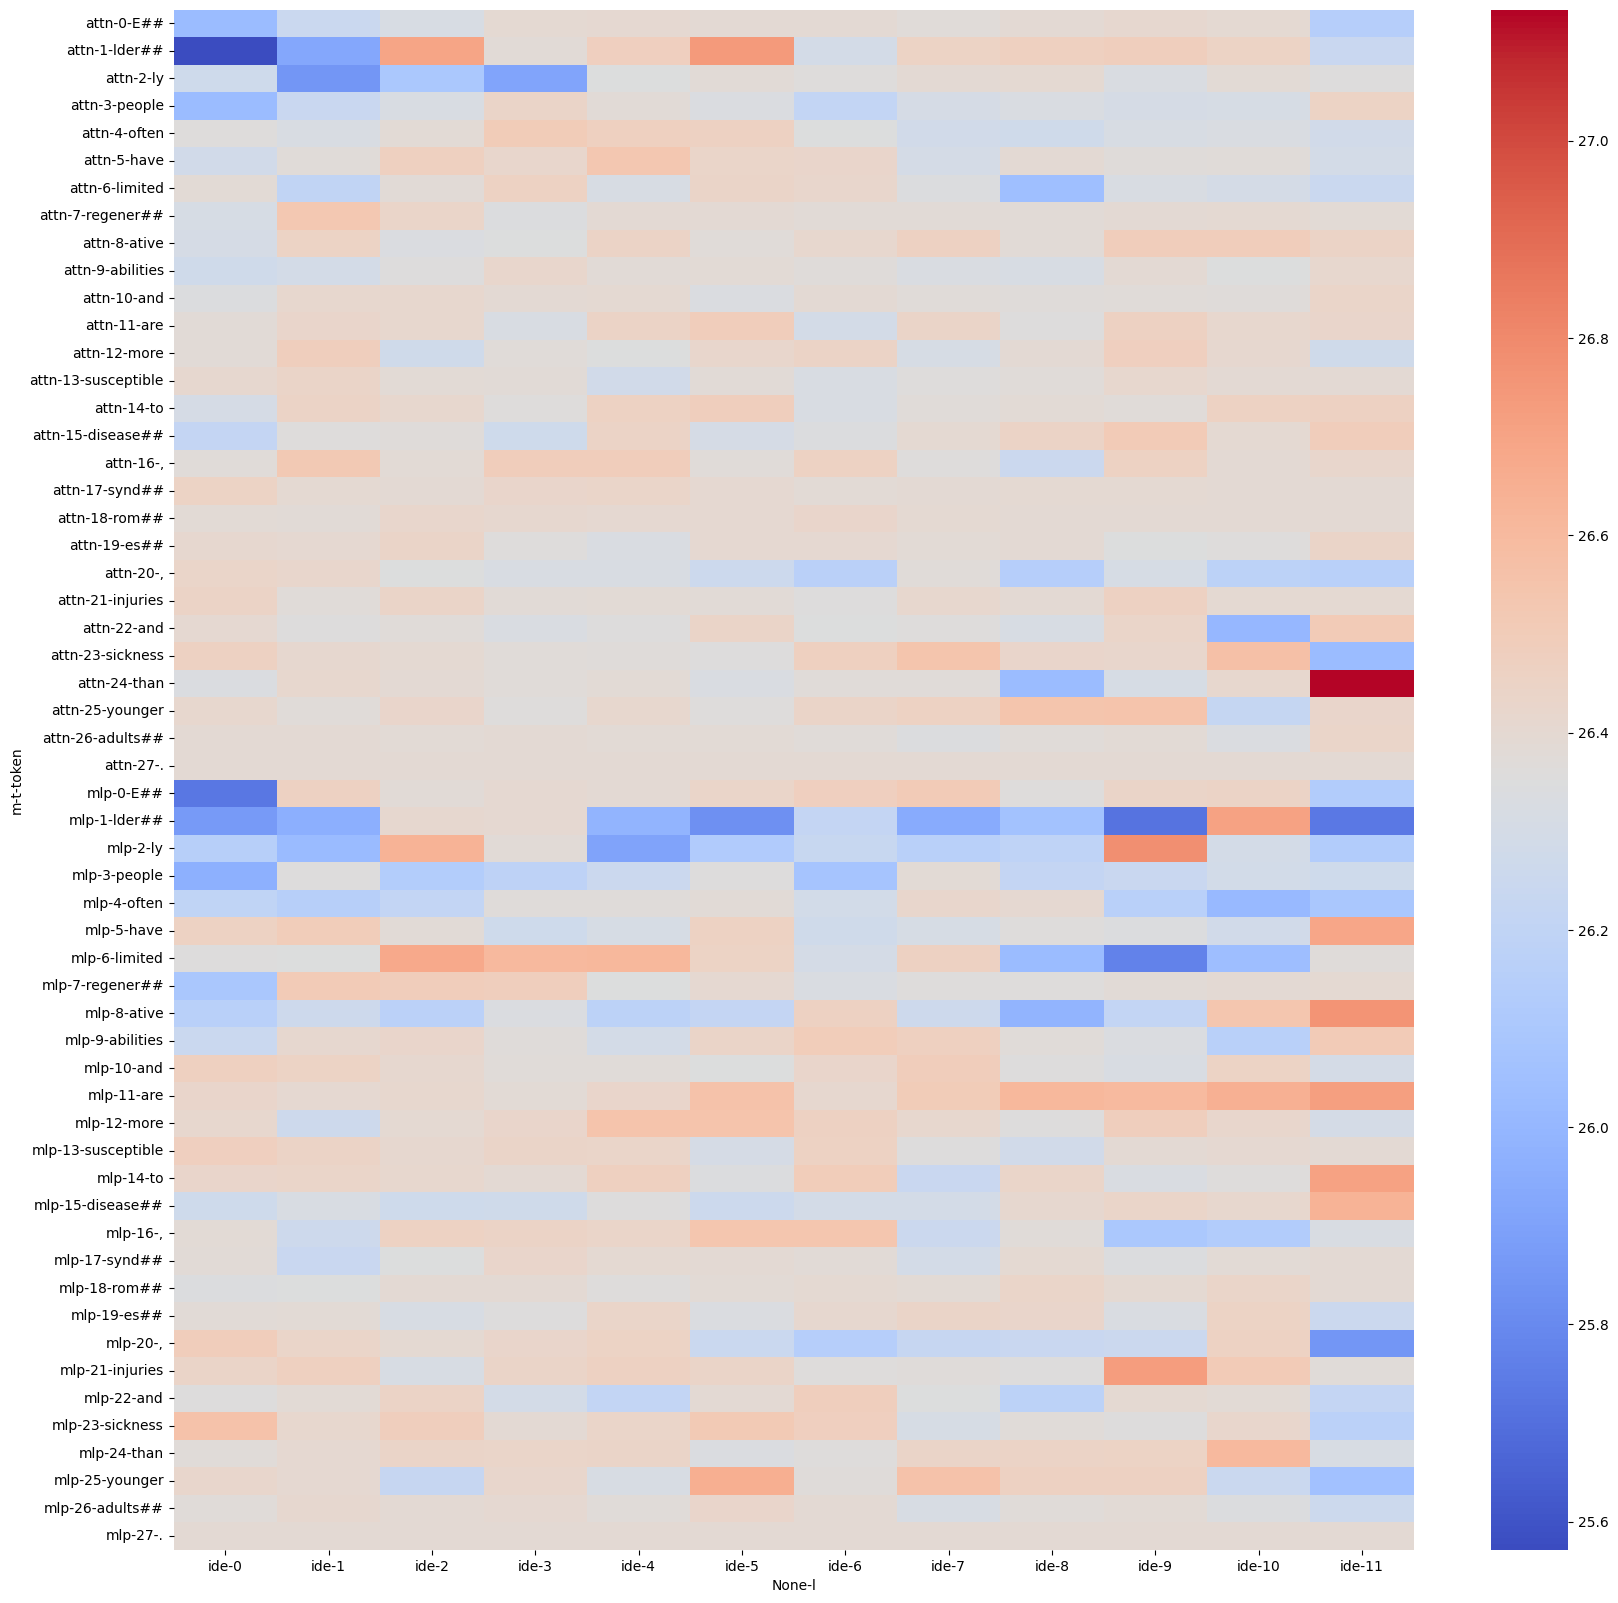

In [37]:
plt.rcParams["figure.figsize"] = (20,20)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 't', 'token', 'l']).unstack(-1),
    cmap='coolwarm'
)

##### The development of ichthyosis in adulthood can be a manifestation of systemic disease, and it has been described in association with malignancies, drugs, endocrine and metabolic disease, HIV, infection, and autoimmune conditions

<Axes: xlabel='None-l', ylabel='m-t-token'>

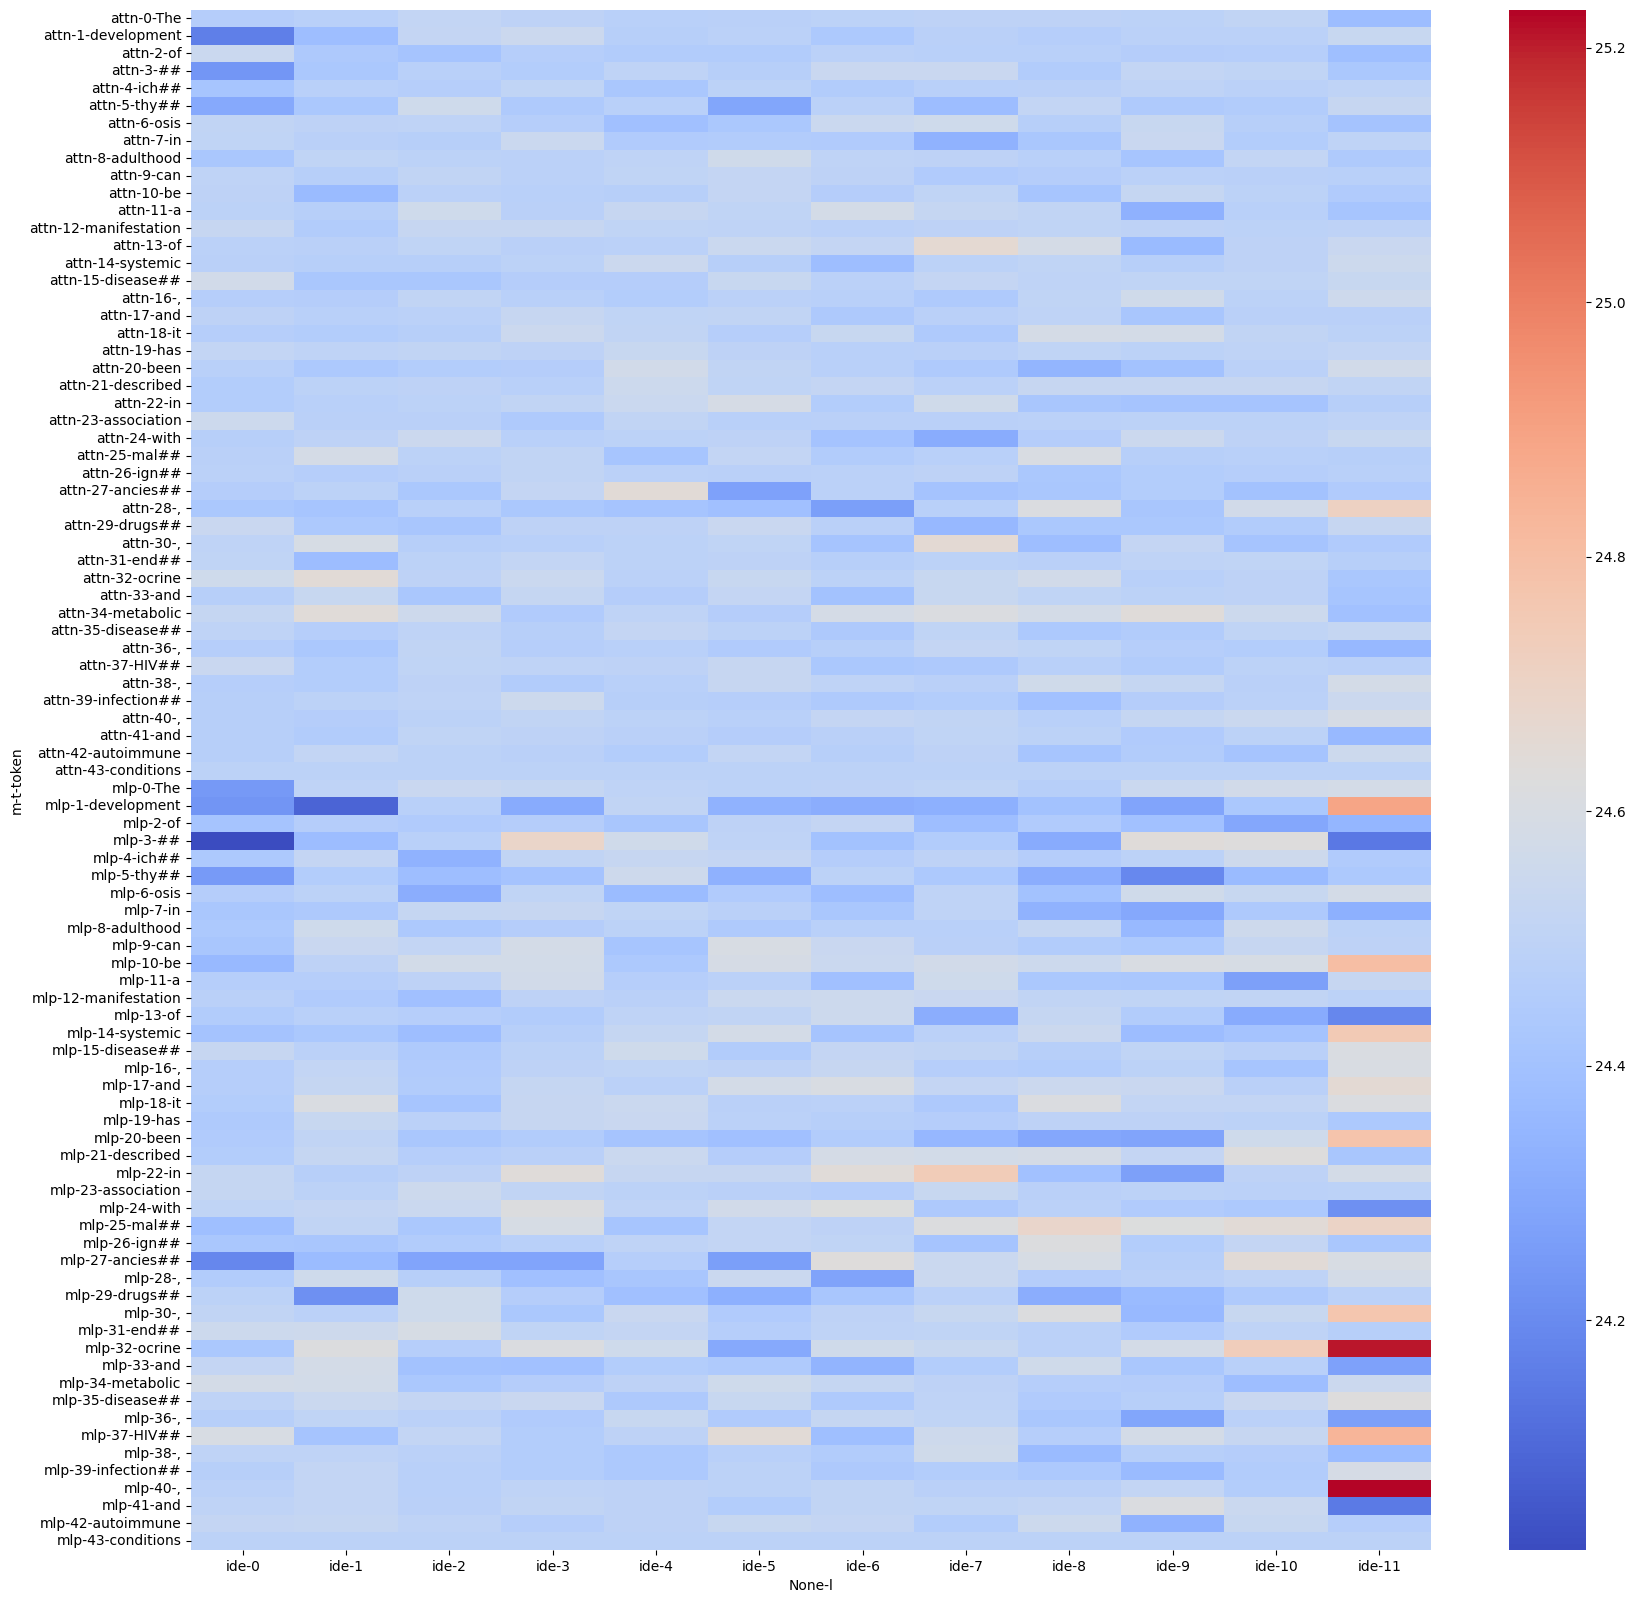

In [49]:
plt.rcParams["figure.figsize"] = (20,20)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 't', 'token', 'l']).unstack(-1),
    cmap='coolwarm'
)

In [39]:
dataset['train']['text'][1770:1780]

['1769,"Autosensitization dermatitis presents with the development of widespread dermatitis or dermatitis distant from a local inflammatory focus, a process referred to as autoeczematization."',
 '1770,',
 '1771,',
 '1772,Ichthyosis acquisita',
 '1773,',
 '1774,Ichthyosis acquisita is a disorder clinically and histologically similar to ichthyosis vulgaris.',
 '1775,Presentation.',
 '1776,Associated conditions.',
 '1777,"The development of ichthyosis in adulthood can be a manifestation of systemic disease, and it has been described in association with malignancies, drugs, endocrine and metabolic disease, HIV, infection, and autoimmune conditions."',
 '1778,"It usually is associated with people who have Hodgkin\'s disease but it is also occurs in people with mycosis fungoides, other malignant sarcomas, Kaposi\'s sarcoma and visceral carcinomas. It can occur in people suffering from leprosy, AIDS, tuberculosis, and typhoid fever."']

In [18]:
import numpy as np

In [19]:
a = torch.Tensor(np.arange(12).reshape(1, 3, 4))

In [20]:
b = torch.Tensor(np.arange(12, 16)).reshape(1, 4)

In [21]:
a[:, 1] = b

In [22]:
a

tensor([[[ 0.,  1.,  2.,  3.],
         [12., 13., 14., 15.],
         [ 8.,  9., 10., 11.]]])

In [319]:
restored_outputs.hidden_states[0].shape

torch.Size([1, 26, 768])

In [323]:
restored_outputs.hidden_states[0]

tensor([[[-0.1474, -0.3854,  0.0719,  ..., -0.0450,  0.0804,  0.0618],
         [-0.1123, -0.1674,  0.0080,  ...,  0.1122, -0.0899,  0.0183],
         [ 0.0172, -0.1266,  0.1396,  ...,  0.1083, -0.1796,  0.0260],
         ...,
         [-0.0760, -0.1217,  0.0956,  ...,  0.1461, -0.0633,  0.0374],
         [-0.1648,  0.0956,  0.2951,  ..., -0.0290, -0.1345,  0.2622],
         [ 0.1380,  0.1554,  0.0436,  ..., -0.0754, -0.1266,  0.1490]]],
       device='cuda:0')

In [324]:
restored_outputs.hidden_states[-1]

tensor([[[-0.1422, -0.0903, -0.2047,  ..., -0.1065, -0.0782,  0.0224],
         [ 0.3319,  0.0680, -1.4159,  ..., -0.2686,  0.2319, -0.1263],
         [ 0.8720,  0.1567, -0.8815,  ...,  0.4944,  0.3042, -0.0509],
         ...,
         [-2.1675,  0.0377,  0.1721,  ..., -0.0354,  0.1528,  0.3442],
         [-1.4497,  0.8844, -1.8824,  ...,  0.6723, -0.7648,  1.1113],
         [-0.7621,  0.4956, -2.3075,  ...,  0.4286,  0.1909,  0.4229]]],
       device='cuda:0')

In [261]:
base_model_activation['transformer.h.0.attn']

AttributeError: 'list' object has no attribute 'shape'

In [200]:
base_model_activation['transformer.h.0.attn'][1][0].shape

torch.Size([1, 12, 6, 64])

In [201]:
base_model_activation['transformer.h.0.attn'][1][1].shape

torch.Size([1, 12, 6, 64])

In [262]:
base_model_activation['transformer.h.0.attn'][0].shape

torch.Size([1, 6, 768])

In [263]:
base_model_activation['transformer.h.0.attn'][0][0].shape

torch.Size([6, 768])

In [206]:
base_model_activation['transformer.h.0.mlp'].shape

torch.Size([1, 6, 768])

In [203]:
base_model_activation['transformer.h.0.mlp'][1][0].shape

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [201]:
base_model_activation['transformer.h.0.mlp'][1][1].shape

torch.Size([1, 12, 6, 64])

In [102]:

#     return hook


# model = MyModel()
# model.fc2.register_forward_hook(get_activation('fc2'))
# x = torch.randn(1, 25)
# output = model(x)
# print(activation['fc2'])

In [86]:
import torch.nn as nn

In [ ]:
nn.Module.()

In [96]:
outputs = base_model(**inputs, output_hidden_states=True)

In [97]:
len(feats)

2

In [99]:
feats

{'feat': [tensor([[[-0.0301, -0.0073, -0.0091,  ..., -0.0105, -0.0744,  0.6182],
           [ 0.1909, -0.1697, -0.1325,  ..., -0.1108, -0.1694, -0.1655],
           [ 0.1474, -0.0252, -0.0461,  ..., -0.1597, -0.1263,  0.0111],
           [ 0.1078, -0.1110, -0.0686,  ..., -0.0815, -0.1464, -0.0997],
           [ 0.2341,  0.0183, -0.1318,  ..., -0.0780, -0.1161, -0.0645],
           [ 0.5379, -0.1639, -0.1694,  ..., -0.1605, -0.0340, -0.1341]]],
         device='cuda:0'),
  tensor([[[-0.0301, -0.0073, -0.0091,  ..., -0.0105, -0.0744,  0.6182],
           [ 0.1909, -0.1697, -0.1325,  ..., -0.1108, -0.1694, -0.1655],
           [ 0.1474, -0.0252, -0.0461,  ..., -0.1597, -0.1263,  0.0111],
           [ 0.1078, -0.1110, -0.0686,  ..., -0.0815, -0.1464, -0.0997],
           [ 0.2341,  0.0183, -0.1318,  ..., -0.0780, -0.1161, -0.0645],
           [ 0.5379, -0.1639, -0.1694,  ..., -0.1605, -0.0340, -0.1341]]],
         device='cuda:0'),
  tensor([[[-0.0301, -0.0073, -0.0091,  ..., -0.0105, -0.0

In [98]:
feats['feat'][0].shape

torch.Size([1, 6, 3072])

In [67]:
for m_id in list_trace_module_ids:
    

IndentationError: expected an indented block (3190203478.py, line 2)

In [41]:
trace_token_id = "transformer.h.{l}.{m}.{t}"
list_trace_token_ids = []


In [ ]:
base_state = {}


In [90]:
# def hook_func(module, _input , _output):
#     feats['feat'].append(output.detach())
    
def save_base_state_hook(module, _input , _output):
    
    feats[list(module.named_modules())[0][0]] = _output.detach()

In [95]:
base_model.transformer.h[0].mlp.act.register_forward_hook(save_base_state_hook)

In [87]:
{k: v for k, v in base_model.transformer.h[0].mlp.named_modules()}

{'': GPT2MLP(
   (c_fc): Conv1D()
   (c_proj): Conv1D()
   (act): NewGELUActivation()
   (dropout): Dropout(p=0.1, inplace=False)
 ),
 'c_fc': Conv1D(),
 'c_proj': Conv1D(),
 'act': NewGELUActivation(),
 'dropout': Dropout(p=0.1, inplace=False)}

In [82]:
{k: v for k, v in base_model.transformer.h[0].mlp.act.named_modules()}

{'': NewGELUActivation()}

In [50]:
# {k:v for k, v in base_model.named_parameters()}

In [51]:
# {k:v for k, v in base_model.named_modules()}

In [53]:
outputs.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states'])

In [42]:
len(outputs['past_key_values'])

12

In [51]:
type(outputs)

transformers.modeling_outputs.CausalLMOutputWithCrossAttentions

In [ ]:
base_model.forward()

In [50]:
outputs['past_key_values'][0][0].shape

torch.Size([1, 12, 5, 64])

In [58]:
outputs['hidden_states'][0]

(tensor([[[ 0.1286, -0.2933,  0.1470,  ...,  0.0599, -0.0342, -0.0586],
          [ 0.1835, -0.1787,  0.0199,  ...,  0.2900,  0.0298,  0.0143],
          [-0.0464, -0.0791,  0.1016,  ...,  0.0623,  0.0928, -0.0598],
          [ 0.0834, -0.0018,  0.1705,  ..., -0.0926, -0.1838,  0.0184],
          [ 0.1294, -0.0446,  0.2036,  ..., -0.1334,  0.1124, -0.1384]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[ 0.0532, -0.7611,  0.4959,  ..., -1.2261, -0.0817,  0.6238],
          [-1.1012, -2.5899, -1.8142,  ...,  1.0625,  0.7677, -0.0037],
          [-1.2581,  0.0095, -0.0184,  ...,  0.0582,  0.1906, -0.4317],
          [-0.4614, -0.7692, -0.3092,  ...,  0.1943, -1.3663,  1.7228],
          [ 0.5679, -0.3924, -1.7748,  ...,  0.4108,  0.9494,  0.9103]]],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[-0.1535, -1.6369,  1.5175,  ..., -0.9826, -0.1340,  0.3355],
          [-0.8389, -3.3402, -1.0746,  ...,  1.9019,  0.4481,  0.1189],
          [-1.2535,  0.1512,  0.

In [48]:
outputs['past_key_values'][0]

(tensor([[[[-1.5577e+00,  2.0585e+00,  1.3060e+00,  ..., -1.3825e+00,
            -6.3336e-01,  1.2624e+00],
           [-2.3259e+00,  2.3836e+00,  2.5165e+00,  ..., -1.5535e+00,
            -1.2954e+00,  2.7215e+00],
           [-2.3145e+00,  2.7101e+00,  1.5073e+00,  ..., -5.7809e-01,
            -1.9292e+00,  2.2634e+00],
           [-1.7966e+00,  2.5474e+00,  2.5459e+00,  ...,  5.4051e-01,
            -1.5586e+00,  1.7831e+00],
           [-2.2192e+00,  3.0667e+00,  1.1398e+00,  ..., -1.7093e+00,
            -1.2971e+00,  2.2413e+00]],
 
          [[-1.1913e-01, -4.7022e-01, -1.8900e+00,  ..., -6.0264e-01,
             1.1491e+00,  9.6728e-02],
           [ 8.0233e-01, -2.1909e+00, -2.6815e+00,  ..., -1.9200e+00,
             2.8771e+00,  4.0363e-01],
           [-7.1399e-01, -1.6105e+00, -2.9748e+00,  ..., -1.6920e+00,
             4.4462e+00,  1.8922e-01],
           [ 1.9563e-01, -2.0327e+00, -3.7951e+00,  ..., -9.0738e-01,
             3.3405e+00,  2.8258e+00],
           [ 9.2

In [ ]:
outputs['past_key_values'][0]